### Library

In [1]:
import os
import time
import random
import timm
import torch
import cv2
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shutil
import wandb
warnings.filterwarnings('ignore')

from albumentations import Compose, RandomBrightnessContrast, Blur, ShiftScaleRotate, GaussNoise, RandomGamma, CLAHE
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from augraphy import (
    InkBleed, BleedThrough, Markup, ColorPaper,
    AugraphyPipeline, PaperFactory)

In [2]:
def random_seed(SEED=42):
    # SEED = 42 # default
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True

random_seed()

### Load Data

In [3]:
train_csv = "../data/train.csv"
inference_csv = "../data/sample_submission.csv"

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(inference_csv)

print(f"Train Data: {train_df.shape}")
print(f"Test Data: {test_df.shape}")

Train Data: (1570, 2)
Test Data: (3140, 2)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "tf_efficientnetv2_xl_in21ft1k" 
img_size = 343 
LR = 1e-4
EPOCHS = 40
BATCH_SIZE = 8
Drop_out = 0.3
num_workers = 2 # GPU 사용

In [5]:
# Count_plot
def count_plot(df, col, figsize=(10, 6), palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel='Count'):
    plt.figure(figsize=figsize)
    sns.countplot(data=df, x=col, palette=palette)
    plt.title(title if title else f'{col} Count')
    plt.xticks(rotation=rotation)
    plt.xlabel(xlabel if xlabel is not None else col)
    plt.ylabel(ylabel)
    plt.show()

# hist plot
def hist_plot(df1, col, df2=None, figsize=(8, 6), bins=30, alpha=0.6, 
              color1='skyblue', color2='salmon', label1=None, label2=None, 
              title=None, density=False):
    plt.figure(figsize=figsize)
    
    stat_mode = 'density' if density else 'count'

    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, 
                 stat=stat_mode, label=label1 if label1 else ('Group 1' if df2 is not None else None))
    
    if df2 is not None:
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, 
                     stat=stat_mode, label=label2 if label2 else 'Group 2')
        plt.legend()

    plt.title(title if title else f'{col} Distribution ({"Density" if density else "Count"} Histogram + KDE)')
    plt.xlabel(col)
    plt.ylabel("Density" if density else "Count")
    plt.show()

# bar plot    
def bar_plot(df, x_col, y_col, figsize=(10, 6), hue=None, palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel=None):
     plt.figure(figsize=figsize)
     
     if hue: # hue 지정
        sns.barplot(x=x_col, y=y_col, hue=hue, data=df, palette=palette)
     else: # hue 지정 X
        sns.barplot(x=x_col, y=y_col, data=df, palette=palette)

     plt.xticks(rotation=rotation)
     plt.title(title)
     plt.xlabel(xlabel)
     plt.ylabel(ylabel)
     plt.show()

# heatmap
def heat_map(df, target_col=None, figsize=(8, 10), threshold=0, cmap='Reds', method='pearson', annot_kws=None, return_data=False):
        df = df.select_dtypes(include=['number'])
        
        if annot_kws is None:
            annot_kws = {"size": 10}

        if target_col is not None:
            corr_series = df.corr(method=method)[target_col].drop(target_col)
            corr_filtered = corr_series[abs(corr_series) >= threshold].sort_values(ascending=False)

            plt.figure(figsize=figsize)
            sns.heatmap(corr_filtered.to_frame(name='Correlation'), annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation with {target_col}', fontsize=14)
            plt.show()

            corr_df = corr_filtered.reset_index()
            corr_df.columns = ['Variable', 'Correlation']

            if return_data:
                return corr_df

        else:
            corr_matrix = df.corr(method=method) # 전체 변수 간 상관계수

            plt.figure(figsize=figsize)
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation Matrix (All Variables)', fontsize=14)
            plt.show()

            if return_data:
                return corr_matrix

### Preprocessing

In [6]:
# 증강 설정
augmentation = A.Compose([
    A.RandomResizedCrop(size=(img_size, img_size), scale=(0.98, 1.0), p=0.2),
    A.RandomBrightnessContrast(limit=0.1, p=0.2),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.2),
    
    # 흐림 효과를 OneOf로 묶음
    A.OneOf([
        A.Blur(blur_limit=2),
        A.MotionBlur(blur_limit=5),
        A.Defocus(radius=(1, 3)),
    ], p=0.3),

    A.Perspective(scale=(0.05, 0.1), keep_size=True, p=0.2),
    A.Affine(shear={"x": (-10, 10), "y": (-10, 10)}, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=5, p=0.2),

    # 회전, 반전 등
    A.OneOf([   
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
    ], p=0.45),
    A.Rotate(limit=[-90, 90], p=0.4),

    # 깨짐·노이즈성 증강도 OneOf로 묶어 한 번에 하나만 적용되도록 제한
    A.OneOf([
        A.GaussNoise(var_limit=(0.0000002, 0.000001), mean=0, p=1.0),  # 은은한 미세 노이즈
        A.ImageCompression(quality_lower=40, quality_upper=60, p=1.0),  # 압축으로 전체적 얼룩
        A.CoarseDropout(max_holes=8, max_height=img_size//10, max_width=img_size//10),
    ], p=0.3),

    A.RandomGamma(gamma_limit=(95, 105), p=0.2),
    A.CLAHE(clip_limit=1.5, p=0.2),
])

# 문서 기반 증강
augraphy_aug = AugraphyPipeline(
    ink_phase=[
        InkBleed(p=0.2),
        BleedThrough(p=0.2),
        Markup(p=0.2),
    ],
    paper_phase=[
        ColorPaper(p=0.2),
    ],
    post_phase=[],
)

# Class 2, 16 제외: 문서 기반 증강
document_classes = set(range(0, 2)) | set(range(3, 16))
save_dir = "../data/V4-augmented"
train_path = '../data/train/'
os.makedirs(save_dir, exist_ok=True)

augmented_records = []

for target_class in sorted(train_df["target"].unique()):
    class_df = train_df[train_df["target"] == target_class]
    current_count = len(class_df)
    print(f"[INFO] Class {target_class}: 현재 {current_count}개 → 목표 250개로 증강 중...")

    # 원본 이미지 복사 후 저장
    for _, row in tqdm(class_df.iterrows(), total=current_count, desc=f"[Class {target_class}] 원본 복사"):
        img_name = row["ID"]
        src = os.path.join(train_path, img_name)
        dst = os.path.join(save_dir, img_name)
        shutil.copy2(src, dst)
        augmented_records.append({"ID": img_name, "target": target_class})

    # 추가로 필요한 증강 개수 계산
    n_to_augment = max(0, 250 - current_count)
    print(f"[INFO] Class {target_class}: 추가 증강 {n_to_augment}개 생성 중...")

    for i in tqdm(range(n_to_augment), desc=f"[Class {target_class}] 추가증강"):
        sample_row = class_df.sample(1).iloc[0]
        img_name = sample_row["ID"]
        img_path = os.path.join(train_path, img_name)
        img = np.array(Image.open(img_path).convert("RGB"))

        # 확률적으로 Augraphy or Albumentations 증강 선택
        if target_class in document_classes and np.random.rand() < 0.5:
            aug_img = augraphy_aug(image=img)
            aug_name = f"augraphy_{target_class}_{i}_{img_name}"
        else:
            aug_img = augmentation(image=img)['image']
            aug_name = f"alb_{target_class}_{i}_{img_name}"

        aug_path = os.path.join(save_dir, aug_name)
        Image.fromarray(aug_img).save(aug_path)
        augmented_records.append({"ID": aug_name, "target": target_class})

print("[완료] 클래스별 250장 증강 완료")

# CSV 저장
aug_df = pd.DataFrame(augmented_records)
aug_df.to_csv("../data/V4-augmented.csv", index=False)
print("[완료] 원본 + 증강 데이터 및 CSV 저장 완료")

[INFO] Class 0: 현재 100개 → 목표 250개로 증강 중...


[Class 0] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 6018.08it/s]


[INFO] Class 0: 추가 증강 150개 생성 중...


[Class 0] 추가증강:   0%|          | 0/150 [00:00<?, ?it/s]

[Class 0] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 39.69it/s]


[INFO] Class 1: 현재 46개 → 목표 250개로 증강 중...


[Class 1] 원본 복사: 100%|██████████| 46/46 [00:00<00:00, 5733.50it/s]


[INFO] Class 1: 추가 증강 204개 생성 중...


[Class 1] 추가증강: 100%|██████████| 204/204 [00:05<00:00, 37.99it/s]


[INFO] Class 2: 현재 100개 → 목표 250개로 증강 중...


[Class 2] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5397.94it/s]


[INFO] Class 2: 추가 증강 150개 생성 중...


[Class 2] 추가증강: 100%|██████████| 150/150 [00:01<00:00, 83.57it/s]


[INFO] Class 3: 현재 100개 → 목표 250개로 증강 중...


[Class 3] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 4595.99it/s]


[INFO] Class 3: 추가 증강 150개 생성 중...


[Class 3] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 39.16it/s]


[INFO] Class 4: 현재 100개 → 목표 250개로 증강 중...


[Class 4] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 6202.11it/s]


[INFO] Class 4: 추가 증강 150개 생성 중...


[Class 4] 추가증강: 100%|██████████| 150/150 [00:04<00:00, 35.66it/s]


[INFO] Class 5: 현재 100개 → 목표 250개로 증강 중...


[Class 5] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5997.69it/s]


[INFO] Class 5: 추가 증강 150개 생성 중...


[Class 5] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 40.52it/s]


[INFO] Class 6: 현재 100개 → 목표 250개로 증강 중...


[Class 6] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5347.56it/s]


[INFO] Class 6: 추가 증강 150개 생성 중...


[Class 6] 추가증강: 100%|██████████| 150/150 [00:04<00:00, 35.38it/s]


[INFO] Class 7: 현재 100개 → 목표 250개로 증강 중...


[Class 7] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 6505.42it/s]


[INFO] Class 7: 추가 증강 150개 생성 중...


[Class 7] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 41.54it/s]


[INFO] Class 8: 현재 100개 → 목표 250개로 증강 중...


[Class 8] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5604.21it/s]


[INFO] Class 8: 추가 증강 150개 생성 중...


[Class 8] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 40.42it/s]


[INFO] Class 9: 현재 100개 → 목표 250개로 증강 중...


[Class 9] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 4590.06it/s]


[INFO] Class 9: 추가 증강 150개 생성 중...


[Class 9] 추가증강: 100%|██████████| 150/150 [00:04<00:00, 34.41it/s]


[INFO] Class 10: 현재 100개 → 목표 250개로 증강 중...


[Class 10] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5919.56it/s]


[INFO] Class 10: 추가 증강 150개 생성 중...


[Class 10] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 39.66it/s]


[INFO] Class 11: 현재 100개 → 목표 250개로 증강 중...


[Class 11] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5772.27it/s]


[INFO] Class 11: 추가 증강 150개 생성 중...


[Class 11] 추가증강: 100%|██████████| 150/150 [00:04<00:00, 36.48it/s]


[INFO] Class 12: 현재 100개 → 목표 250개로 증강 중...


[Class 12] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5963.66it/s]


[INFO] Class 12: 추가 증강 150개 생성 중...


[Class 12] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 39.21it/s]


[INFO] Class 13: 현재 74개 → 목표 250개로 증강 중...


[Class 13] 원본 복사: 100%|██████████| 74/74 [00:00<00:00, 5980.20it/s]


[INFO] Class 13: 추가 증강 176개 생성 중...


[Class 13] 추가증강: 100%|██████████| 176/176 [00:04<00:00, 39.57it/s]


[INFO] Class 14: 현재 50개 → 목표 250개로 증강 중...


[Class 14] 원본 복사: 100%|██████████| 50/50 [00:00<00:00, 5945.15it/s]


[INFO] Class 14: 추가 증강 200개 생성 중...


[Class 14] 추가증강: 100%|██████████| 200/200 [00:05<00:00, 38.42it/s]


[INFO] Class 15: 현재 100개 → 목표 250개로 증강 중...


[Class 15] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5673.27it/s]


[INFO] Class 15: 추가 증강 150개 생성 중...


[Class 15] 추가증강: 100%|██████████| 150/150 [00:04<00:00, 37.14it/s]


[INFO] Class 16: 현재 100개 → 목표 250개로 증강 중...


[Class 16] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5685.65it/s]


[INFO] Class 16: 추가 증강 150개 생성 중...


[Class 16] 추가증강: 100%|██████████| 150/150 [00:01<00:00, 81.16it/s]

[완료] 클래스별 250장 증강 완료
[완료] 원본 + 증강 데이터 및 CSV 저장 완료


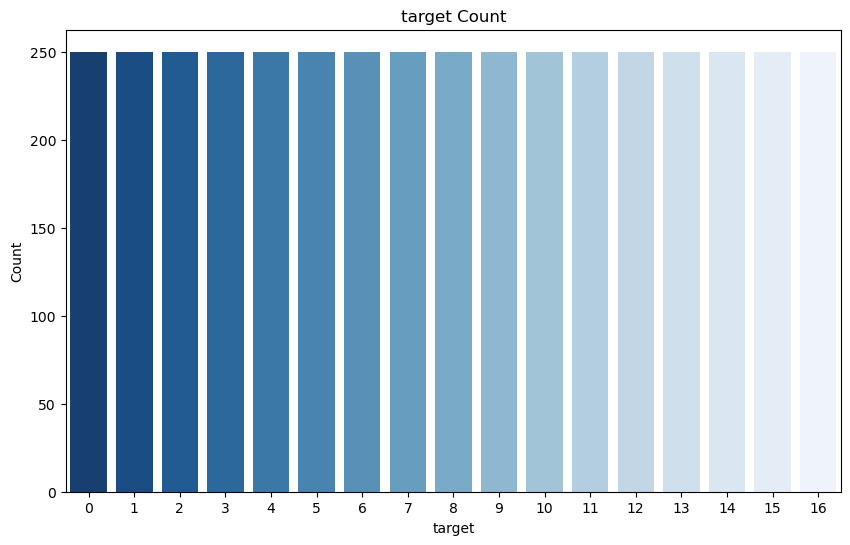

,ID,target
0,06c04208033a0ebf.jpg,0
1,07a0a849cab135e0.jpg,0
2,096c4b74a832db46.jpg,0
3,097bf6816bf11df3.jpg,0
4,0cdf7f30dbeacb1c.jpg,0
...,...,...
4245,alb_16_145_461eea7d62965d0e.jpg,16
4246,alb_16_146_64de0d5782390458.jpg,16
4247,alb_16_147_b27747c52c58fc0b.jpg,16
4248,alb_16_148_392a24cddc8df59f.jpg,16


In [6]:
# Class check
aug_df = pd.read_csv("../data/V4-augmented.csv")
count_plot(df=aug_df, col='target')
aug_df

In [7]:
class ImageDataset(Dataset):
    def __init__(self, df, path, transform=None):
        self.df = df.values 
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [8]:
train_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),   # 1) 이미지 크기 통일
    A.Normalize(                                 # 2) 픽셀 정규화
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),                                # 3) 텐서 변환
])

test_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),   # 1) 이미지 크기 통일
    A.Normalize(                                 # 2) 픽셀 정규화
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),                                # 3) 텐서 변환
])

train_agument_path = '../data/V4-agumented/'
test_path = '../data/test/'

In [12]:
# StratifiedKFold 설정
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(aug_df, aug_df['target'])):
    print(f"\n=== Fold {fold+1} ===")
    train_fold_df = aug_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = aug_df.iloc[val_idx].reset_index(drop=True)

    train_dataset = ImageDataset(train_fold_df, path="../data/V4-augmented", transform=train_transform)
    val_dataset = ImageDataset(val_fold_df, path="../data/V4-augmented", transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
    print(f"Fold {fold+1}: Train samples={len(train_fold_df)}, Val samples={len(val_fold_df)}")

    # 모델 정의
    model = timm.create_model(model_name, pretrained=True, num_classes=17, drop_path_rate=Drop_out).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,        # 처음 warm restart 주기 (5 에폭)
    T_mult=2,     # 이후 주기를 배수로 늘림
    eta_min=1e-6  # 최소 학습률
)

    best_f1 = -1.0
    patience = 3
    trigger = 0

    os.environ["WANDB_DIR"] = "../../"

    wandb.init(
    project="Document Classification",
    entity="moonstalker9010-none",
    name=f"V4-fold_{fold+1}",
    config={
        "epochs": EPOCHS,
        "img_size": img_size,
        "batch_size": BATCH_SIZE,
        "learning_rate": LR,
        "Drop_out": Drop_out,
        "model_name": model_name,
        "train_samples": len(train_fold_df),
        "val_samples": len(val_fold_df),
    }
)
    
    wandb.log({
    "Train_Data": len(train_fold_df),
    "Val_Data": len(val_fold_df),
})

    for epoch in range(1, EPOCHS + 1):
        # 학습
        model.train()
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"[Fold {fold+1}][Epoch {epoch}/{EPOCHS}] Training")
        for images, targets in train_bar:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)

        # 검증
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []
        scheduler.step()

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"[Fold {fold+1}][Epoch {epoch}/{EPOCHS}] Validation")
            for images, targets in val_bar:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

                correct += (preds == targets).sum().item()
                total += targets.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        val_f1 = f1_score(all_targets, all_preds, average='macro')

        print(f"[F{fold+1}] Ep{epoch} - "
              f"Train: {avg_train_loss:.4f} | VaL: {avg_val_loss:.4f}, "
              f"Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
        
        current_lr = optimizer.param_groups[0]['lr']
        wandb.log({
            "fold": fold + 1,
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_acc": val_acc,
            "val_f1": val_f1,
            "lr": current_lr,
        })

        # EarlyStopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            trigger = 0
            save_dir = "../model/V4"
            os.makedirs(save_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(save_dir, f"model_fold{fold+1}.pth"))
        else:
            trigger += 1
            if trigger >= patience:
                print(f"[Fold {fold+1}] Early stopping triggered. Best F1: {best_f1:.4f}")
                break

    wandb.finish()


=== Fold 1 ===
Fold 1: Train samples=2833, Val samples=1417


model.safetensors:   0%|          | 0.00/836M [00:00<?, ?B/s]

wandb: Currently logged in as: moonstalker9010 (moonstalker9010-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[Fold 1][Epoch 1/40] Validation: 100%|██████████| 178/178 [00:12<00:00, 14.35it/s]


[F1] Ep1 - Train: 0.8574 | VaL: 0.3300, Acc: 0.8920, F1: 0.8945


[Fold 1][Epoch 2/40] Validation: 100%|██████████| 178/178 [00:12<00:00, 14.34it/s]


[F1] Ep2 - Train: 0.2287 | VaL: 0.2026, Acc: 0.9428, F1: 0.9414


[Fold 1][Epoch 3/40] Validation: 100%|██████████| 178/178 [00:12<00:00, 14.28it/s]


[F1] Ep3 - Train: 0.1148 | VaL: 0.1618, Acc: 0.9570, F1: 0.9564


[Fold 1][Epoch 4/40] Validation: 100%|██████████| 178/178 [00:12<00:00, 14.32it/s]


[F1] Ep4 - Train: 0.0440 | VaL: 0.1239, Acc: 0.9675, F1: 0.9673


[Fold 1][Epoch 5/40] Validation: 100%|██████████| 178/178 [00:12<00:00, 14.39it/s]


[F1] Ep5 - Train: 0.0257 | VaL: 0.1171, Acc: 0.9675, F1: 0.9674


[Fold 1][Epoch 6/40] Validation: 100%|██████████| 178/178 [00:12<00:00, 14.33it/s]


[F1] Ep6 - Train: 0.2303 | VaL: 0.2271, Acc: 0.9407, F1: 0.9391


[Fold 1][Epoch 7/40] Validation: 100%|██████████| 178/178 [00:12<00:00, 14.32it/s]


[F1] Ep7 - Train: 0.1252 | VaL: 0.3847, Acc: 0.9090, F1: 0.9072


[Fold 1][Epoch 8/40] Validation: 100%|██████████| 178/178 [00:12<00:00, 14.28it/s]


[F1] Ep8 - Train: 0.0942 | VaL: 0.1588, Acc: 0.9605, F1: 0.9605
[Fold 1] Early stopping triggered. Best F1: 0.9674


Train_Data,▁
Val_Data,▁
epoch,▁▂▃▄▅▆▇█
fold,▁▁▁▁▁▁▁▁
lr,▇▅▃▁██▇▆
train_loss,█▃▂▁▁▃▂▂
val_acc,▁▆▇██▆▃▇
val_f1,▁▆▇██▅▂▇
val_loss,▇▃▂▁▁▄█▂
Train_Data,2833
Val_Data,1417



=== Fold 2 ===
Fold 2: Train samples=2833, Val samples=1417


[Fold 2][Epoch 1/40] Validation: 100%|██████████| 178/178 [00:12<00:00, 14.36it/s]


[F2] Ep1 - Train: 0.9178 | VaL: 0.2592, Acc: 0.9118, F1: 0.9128


[Fold 2][Epoch 2/40] Validation: 100%|██████████| 178/178 [00:12<00:00, 14.37it/s]


[F2] Ep2 - Train: 0.2452 | VaL: 0.1694, Acc: 0.9421, F1: 0.9421


[Fold 2][Epoch 3/40] Validation: 100%|██████████| 178/178 [00:12<00:00, 14.32it/s]


[F2] Ep3 - Train: 0.1202 | VaL: 0.1489, Acc: 0.9485, F1: 0.9485


[Fold 2][Epoch 4/40] Validation: 100%|██████████| 178/178 [00:12<00:00, 14.35it/s]


[F2] Ep4 - Train: 0.0530 | VaL: 0.1221, Acc: 0.9570, F1: 0.9568


[Fold 2][Epoch 5/40] Validation: 100%|██████████| 178/178 [00:12<00:00, 14.38it/s]


[F2] Ep5 - Train: 0.0280 | VaL: 0.1240, Acc: 0.9591, F1: 0.9590


[Fold 2][Epoch 6/40] Validation: 100%|██████████| 178/178 [00:12<00:00, 14.38it/s]


[F2] Ep6 - Train: 0.2222 | VaL: 0.3039, Acc: 0.9097, F1: 0.9050


[Fold 2][Epoch 7/40] Validation: 100%|██████████| 178/178 [00:12<00:00, 14.32it/s]


[F2] Ep7 - Train: 0.1560 | VaL: 0.2048, Acc: 0.9499, F1: 0.9492


[Fold 2][Epoch 8/40] Validation: 100%|██████████| 178/178 [00:12<00:00, 14.29it/s]

[F2] Ep8 - Train: 0.0598 | VaL: 0.1641, Acc: 0.9534, F1: 0.9539
[Fold 2] Early stopping triggered. Best F1: 0.9590


Train_Data,▁
Val_Data,▁
epoch,▁▂▃▄▅▆▇█
fold,▁▁▁▁▁▁▁▁
lr,▇▅▃▁██▇▆
train_loss,█▃▂▁▁▃▂▁
val_acc,▁▆▆██▁▇▇
val_f1,▂▆▇██▁▇▇
val_loss,▆▃▂▁▁█▄▃
Train_Data,2833
Val_Data,1417



=== Fold 3 ===
Fold 3: Train samples=2834, Val samples=1416


[Fold 3][Epoch 1/40] Validation: 100%|██████████| 177/177 [00:12<00:00, 14.28it/s]


[F3] Ep1 - Train: 0.8211 | VaL: 0.3411, Acc: 0.8969, F1: 0.8949


[Fold 3][Epoch 2/40] Validation: 100%|██████████| 177/177 [00:12<00:00, 14.28it/s]


[F3] Ep2 - Train: 0.2331 | VaL: 0.2311, Acc: 0.9287, F1: 0.9302


[Fold 3][Epoch 3/40] Validation: 100%|██████████| 177/177 [00:12<00:00, 14.29it/s]


[F3] Ep3 - Train: 0.1118 | VaL: 0.1968, Acc: 0.9414, F1: 0.9412


[Fold 3][Epoch 4/40] Validation: 100%|██████████| 177/177 [00:12<00:00, 14.30it/s]


[F3] Ep4 - Train: 0.0392 | VaL: 0.1609, Acc: 0.9555, F1: 0.9554


[Fold 3][Epoch 5/40] Validation: 100%|██████████| 177/177 [00:12<00:00, 14.27it/s]


[F3] Ep5 - Train: 0.0175 | VaL: 0.1619, Acc: 0.9555, F1: 0.9553


[Fold 3][Epoch 6/40] Validation: 100%|██████████| 177/177 [00:12<00:00, 14.26it/s]


[F3] Ep6 - Train: 0.1791 | VaL: 0.4868, Acc: 0.8757, F1: 0.8758


[Fold 3][Epoch 7/40] Validation: 100%|██████████| 177/177 [00:12<00:00, 14.25it/s]

[F3] Ep7 - Train: 0.1734 | VaL: 0.3370, Acc: 0.9181, F1: 0.9195
[Fold 3] Early stopping triggered. Best F1: 0.9554


Train_Data,▁
Val_Data,▁
epoch,▁▂▃▅▆▇█
fold,▁▁▁▁▁▁▁
lr,▇▅▃▁██▇
train_loss,█▃▂▁▁▂▂
val_acc,▃▆▇██▁▅
val_f1,▃▆▇██▁▅
val_loss,▅▃▂▁▁█▅
Train_Data,2834
Val_Data,1416


### Ensemble & Inference

In [9]:
# fold별 모델 로드
models = []
for fold in range(3):
    model = timm.create_model(model_name, pretrained=False, num_classes=17, drop_path_rate=Drop_out)
    model.load_state_dict(torch.load(f"../model/V4/model_fold{fold+1}.pth", map_location=device))
    model.to(device)
    model.eval()
    models.append(model)

# 가중치 계산
fold_f1s = np.array([0.9674, 0.9590, 0.9554])
fold_weights = fold_f1s / fold_f1s.sum()  # 합이 1이 되도록 정규화

In [10]:
test_dataset = ImageDataset(test_df, test_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

submission_preds = []

with torch.no_grad():
    for images, _ in tqdm(test_loader, desc="Ensemble Inference"):
        images = images.to(device)

        weighted_probs = None
        for weight, model in zip(fold_weights, models):
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            if weighted_probs is None:
                weighted_probs = weight * probs
            else:
                weighted_probs += weight * probs

        preds = torch.argmax(weighted_probs, dim=1)
        submission_preds.extend(preds.cpu().numpy())

# 결과 저장
submission_df = test_df.copy()
submission_df["target"] = submission_preds
submission_df.to_csv("../data/V4-submission.csv", index=False)
print("V4-submission.csv 저장 완료")

Ensemble Inference: 100%|██████████| 393/393 [01:18<00:00,  5.00it/s]

V4-submission.csv 저장 완료
